In [306]:
from hatchet import *
import json
from state import State
from preprocess import PreProcess
import numpy as np
import utils
import random
import os
import seaborn as sns
from scipy import stats
import statsmodels.nonparametric.api as smnp

In [307]:
dirname = '/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow'
# dirname = '/home/vidi/Work/llnl/CallFlow/.callflow'
dataset = 'calc-pi'

In [308]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format

# Read entire dataset

In [309]:
def replace_str_with_Node(df, graph):
        mapper = {}
        def dfs_recurse(root):
            for node in root.children: 
                mapper[node.callpath[-1]] = Node(node.nid, node.callpath, None)
                dfs_recurse(node)
        for root in graph.roots:
            mapper[root.callpath[-1]] = Node(root.nid, root.callpath, None)
            dfs_recurse(root)
        df['node'] = df['node'].apply(lambda node: mapper[node] if node in mapper else '')
        return df

In [310]:
def write_gf(state, state_name, format_of_df, write_graph=True):
    print('writing file for {0} format'.format(format_of_df))

    if write_graph:
        # dump the entire_graph as literal
        graph_literal = state.graph.to_literal(graph=state.graph, dataframe=state.df)
        graph_filepath = dirname + '/' + state_name + '/' + format_of_df + '_graph.json'
        print('File path: {0}'.format(graph_filepath))
        with open(graph_filepath, 'w') as graphFile:
            json.dump(graph_literal, graphFile)

    # dump the filtered dataframe to csv.
    df_filepath = dirname + '/' + state_name + '/' + format_of_df + '_df.csv'
    state.df.to_csv(df_filepath)

In [311]:
def read_gf(name):
    state = State()
    df_filepath = dirname + '/' + name +  '/filter_df.csv'
    entire_df_filepath = dirname + '/' + name + '/entire_df.csv'
    graph_filepath = dirname + '/' + name + '/filter_graph.json'
    entire_graph_filepath = dirname + '/' + name + '/entire_graph.json'   
    group_df_filepath = dirname + '/' + name + '/group_df.csv'

    with open(graph_filepath, 'r') as graphFile:
        data = json.load(graphFile)

    state.gf = GraphFrame()
    state.gf.from_literal_persist(data)

    with open(entire_graph_filepath, 'r') as entire_graphFile:
        entire_data = json.load(entire_graphFile)
            
    state.entire_gf = GraphFrame()
    state.entire_gf.from_literal_persist(entire_data)

    state.df = pd.read_csv(df_filepath)
    state.entire_df = pd.read_csv(entire_df_filepath)

    state.graph = state.gf.graph
    state.entire_graph = state.entire_gf.graph

    # replace df['node'] from str to the Node object.
    state.df = replace_str_with_Node(state.df, state.graph)
    state.entire_df = replace_str_with_Node(state.entire_df, state.entire_graph)
    
    state.group_df = pd.read_csv(group_df_filepath)

    return state

In [312]:
##############################################################################
# Copyright (c) 2018-2019, Lawrence Livermore National Security, LLC.
# Produced at the Lawrence Livermore National Laboratory.
#
# This file is part of Callflow.
# Created by Suraj Kesavan <kesavan1@llnl.gov>.
# LLNL-CODE-741008. All rights reserved.
#
# For details, see: https://github.com/LLNL/Callflow
# Please also read the LICENSE file for the MIT License notice.
##############################################################################

#!/usr/bin/env python3

import pandas as pd
import time 
import utils
from logger import log

class Filter:
    '''
    Filter the graphframe.
    Input: State object, parameter to filterBy (could be inclusive/exclusive, 
            filterPerc: user provided filter percentage (1-100))
    '''
    def __init__(self, state, filterBy, filterPerc):
        utils.debug('filter By:', filterBy)
        utils.debug('filter Perc:', filterPerc)
        self.state = state
        self.graph = state.entire_graph
        self.df = state.entire_df
        self.gf = state.entire_gf

        self.df.set_index(['node', 'rank'], drop=False, inplace=True)

        # self.df = pd.MultiIndex.from_frame(self.df, names=['node', 'rank'])
        self.gf.dataframe = self.df
        
        self.filterBy = filterBy
        self.filterPercInDecimals = int(filterPerc)/100
        # self.filterPercInDecimals = 0.001 
        
        self.fgf = self.run() 
        self.fgf = self.graft()

        # update df and graph after filtering.
        self.df = self.fgf.dataframe
        self.graph = self.fgf.graph

    def run(self):
        log.info('Filtering the graph.')
        t = time.time()
        if self.filterBy == "Inclusive":
            max_inclusive_time = utils.getMaxIncTime_from_gf(self.graph, self.df)
            filter_gf = self.gf.filter(lambda x: True if(x['time (inc)'] > self.filterPercInDecimals*max_inclusive_time) else False)
        elif filterBy == "Exclusive":
            max_exclusive_time = utils.getMaxExcTime_from_gf(self.graph, self.df)
            log.info('[Filter] By Exclusive time = {0})'.format(max_exclusive_time))
            filter_gf = self.gf.filter(lambda x: True if (x['time'] >= self.filterPercInDecimals*max_exclusive_time) else False)
        else:
            log.warn("Not filtering.... Can take forever. Thou were warned")
            filter_gf = self.gf
        
        log.info('[Filter] Removed {0} rows. (time={1})'.format(self.gf.dataframe.shape[0] - filter_gf.dataframe.shape[0], time.time() - t))

        return filter_gf

    def graft(self):
        log.info("Squashing the graph.")
        t = time.time()
        fgf = self.fgf.squash()
        log.info("[Squash] {1} rows in dataframe (time={0})".format(time.time() - t, fgf.dataframe.shape[0]))
        return fgf

In [313]:
def ffilter(state, filterBy, filterPerc):
        filter_obj = Filter(state, filterBy, filterPerc)

        state.gf = filter_obj.gf
        state.df = filter_obj.df
        state.graph = filter_obj.graph

        return state

In [314]:
state = read_gf(dataset)

In [315]:
print(state.df)

                   node  rank   time (inc)       time  nid  rank.1  \
0        <program root>     0   999,238.00       0.00    2       0   
1        <program root>     1   999,390.00       0.00    2       1   
2        <program root>     2 1,000,306.00       0.00    2       2   
3        <program root>     3   999,308.00       0.00    2       3   
4                  main     0   999,238.00       0.00    4       0   
..                  ...   ...          ...        ...  ...     ...   
63  <unknown procedure>     3   173,876.00       0.00   54       3   
64     <unknown file>:0     0   197,718.00 197,718.00   55       0   
65     <unknown file>:0     1   244,939.00 244,939.00   55       1   
66     <unknown file>:0     2   221,846.00 221,846.00   55       2   
67     <unknown file>:0     3   173,876.00 173,876.00   55       3   

                   name type            file  line                     module  \
0        <program root>   PF  <unknown file>     0        libmonitor.so.0.0.0 

# Half-calc-pi dataset

In [316]:
def setvalues(state):
    random = pd.Series(np.random.rand(state.df.shape[0]))
    print(random)
    state.df['time (inc)'] = state.df['time (inc)']*random
    state.df['time'] = state.df['time']*random
    state.entire_df['time (inc)'] = state.entire_df['time (inc)']*random
    state.entire_df['time'] = state.entire_df['time']*random
    state.group_df['time (inc)'] = state.group_df['time (inc)']*random
    return state

In [317]:
def create_dot_callflow_folder(dataset):
            dataset_dir = dirname + '/' + dataset
            if not os.path.exists(dataset_dir):
                utils.debug('Creating .callflow directory for dataset : {0}'.format(dataset))
                os.makedirs(dataset_dir)
    
            files = ["entire_df.csv", "filter_df.csv", "entire_graph.json", "filter_graph.json", "group_df.csv"]
            for f in files:
                if not os.path.exists(dataset_dir + '/' + f):
                    open(os.path.join(dataset_dir, f), 'w').close()

In [318]:
def create_n_runs(incoming_dataset, n, filterBy, filterPerc):
    states = {}
    for i in range(0, n):
        print("Reading dataset: ", incoming_dataset)
        state = read_gf(incoming_dataset)
        dataset = incoming_dataset + '-random-' + str(i)
        create_dot_callflow_folder(dataset)
        state = setvalues(state)
        states[dataset] = state
        write_gf(state, dataset, 'entire')
        print("Writing to entire dataset: ", dataset)
        state = ffilter(state, filterBy, filterPerc) 
        print("Writing to filter dataset: ", dataset)
        write_gf(state, dataset, 'filter')
        df_filepath = dirname + '/' + dataset + '/' +'group_df.csv'
        state.group_df.to_csv(df_filepath)
    return states

In [321]:
states = create_n_runs('calc-pi', 10, 'Inclusive', 1)

Reading dataset:  calc-pi
0    0.57
1    0.24
2    0.52
3    0.43
4    0.31
     ... 
63   0.37
64   0.21
65   0.69
66   0.91
67   0.90
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
   node  rank  time (inc)  time  nid  rank.1  name type         file  line  \
4  main     0  310,679.98  0.00    4       0  main   PF  ./src/cpi.c    19   
5  main     1  253,033.76  0.00    4       1  main   PF  ./src/cpi.c    19   
6  main     2   83,405.61  0.00    4       2  main   PF  ./src/cpi.c    19   
7  main     3  869,757.75  0.00    4       3  main   PF  ./src/cpi.c    19   

  module node.1  n_index  mod_index                             callees  \
4    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize']   
5    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize']   
6    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize']   
7    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize'] 

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.


 17
Nodes: dict_keys([('162:MPIDI_CH3_Finalize', 33), ('230:psm_dofinalize', 35), ('294:MPID_Finalize', 31), ('36:<unknown procedure>', 37), ('62:MPI_Finalize', 27), ('<program root>', 2), ('<unknown file>:0', 44), ('<unknown file>:0', 47), ('<unknown file>:0', 55), ('<unknown procedure>', 39), ('<unknown procedure>', 41), ('<unknown procedure>', 43), ('<unknown procedure>', 46), ('<unknown procedure>', 49), ('<unknown procedure>', 54), ('PMPI_Finalize', 29), ('main', 4)])
2 ('<program root>',)
             node  rank  time (inc)  time  nid  rank.1            name type  \
0  <program root>     0  570,685.37  0.00    2       0  <program root>   PF   
1  <program root>     1  235,502.95  0.00    2       1  <program root>   PF   
2  <program root>     2  521,434.58  0.00    2       2  <program root>   PF   
3  <program root>     3  430,250.44  0.00    2       3  <program root>   PF   

             file  line               module          node.1  n_index  \
0  <unknown file>     0  libmon

 CallFlow:  [Filter] Removed 112 rows. (time=0.05788707733154297)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.08447504043579102)


<program root>
                               node  rank  time (inc)  time  nid  rank.1  \
node           rank                                                        
<program root> 0     <program root>     0  570,685.37  0.00    2       0   
               1     <program root>     1  235,502.95  0.00    2       1   
               2     <program root>     2  521,434.58  0.00    2       2   
               3     <program root>     3  430,250.44  0.00    2       3   

                               name type            file  line  \
node           rank                                              
<program root> 0     <program root>   PF  <unknown file>     0   
               1     <program root>   PF  <unknown file>     0   
               2     <program root>   PF  <unknown file>     0   
               3     <program root>   PF  <unknown file>     0   

                                  module          node.1  n_index  mod_index  \
node           rank                                

31 ('<program root>', 'main', '62:MPI_Finalize', 'PMPI_Finalize', '294:MPID_Finalize')
                                     node  rank  time (inc)  time  nid  \
node              rank                                                   
294:MPID_Finalize 0     294:MPID_Finalize     0   99,281.35  0.00   31   
                  1     294:MPID_Finalize     1  767,919.75  0.00   31   
                  2     294:MPID_Finalize     2   71,999.89  0.00   31   
                  3     294:MPID_Finalize     3  373,583.53  0.00   31   

                        rank.1               name type  \
node              rank                                   
294:MPID_Finalize 0          0  294:MPID_Finalize   PF   
                  1          1  294:MPID_Finalize   PF   
                  2          2  294:MPID_Finalize   PF   
                  3          3  294:MPID_Finalize   PF   

                                                                     file  \
node              rank                    

59  <unknown file>:0  (('<program root>', 'main', '62:MPI_Finalize',...  
- - - - - - - - - - - - Node = <unknown file>:0[47] time (inc) = 158422.66681858062 time = 158422.66681858062
Number of nodes in graph 17
Dataframe Information
Size: (68, 19)
Number of nodes in dataframe:  17
Nodes: dict_keys([('162:MPIDI_CH3_Finalize', 33), ('230:psm_dofinalize', 35), ('294:MPID_Finalize', 31), ('36:<unknown procedure>', 37), ('62:MPI_Finalize', 27), ('<program root>', 2), ('<unknown file>:0', 44), ('<unknown file>:0', 47), ('<unknown file>:0', 55), ('<unknown procedure>', 39), ('<unknown procedure>', 41), ('<unknown procedure>', 43), ('<unknown procedure>', 46), ('<unknown procedure>', 49), ('<unknown procedure>', 54), ('PMPI_Finalize', 29), ('main', 4)])
2 ('<program root>',)
             node  rank  time (inc)  time  nid  rank.1            name type  \
0  <program root>     0  218,624.41  0.00    2       0  <program root>   PF   
1  <program root>     1   31,298.05  0.00    2       1  <progra

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.03243899345397949)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.06257820129394531)


Writing to entire dataset:  calc-pi-random-1
<program root>
                               node  rank  time (inc)  time  nid  rank.1  \
node           rank                                                        
<program root> 0     <program root>     0  218,624.41  0.00    2       0   
               1     <program root>     1   31,298.05  0.00    2       1   
               2     <program root>     2   67,943.74  0.00    2       2   
               3     <program root>     3  736,435.50  0.00    2       3   

                               name type            file  line  \
node           rank                                              
<program root> 0     <program root>   PF  <unknown file>     0   
               1     <program root>   PF  <unknown file>     0   
               2     <program root>   PF  <unknown file>     0   
               3     <program root>   PF  <unknown file>     0   

                                  module          node.1  n_index  mod_index  \
node  

Reading dataset:  calc-pi
0    0.70
1    0.95
2    0.71
3    0.06
4    0.26
     ... 
63   0.29
64   0.35
65   0.47
66   0.41
67   0.06
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
   node  rank  time (inc)  time  nid  rank.1  name type         file  line  \
4  main     0  262,103.32  0.00    4       0  main   PF  ./src/cpi.c    19   
5  main     1  915,513.55  0.00    4       1  main   PF  ./src/cpi.c    19   
6  main     2  826,909.30  0.00    4       2  main   PF  ./src/cpi.c    19   
7  main     3   15,978.91  0.00    4       3  main   PF  ./src/cpi.c    19   

  module node.1  n_index  mod_index                             callees  \
4    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize']   
5    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize']   
6    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize']   
7    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize'] 

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.03186488151550293)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.06427407264709473)



47 ('<program root>', 'main', '62:MPI_Finalize', 'PMPI_Finalize', '294:MPID_Finalize', '162:MPIDI_CH3_Finalize', '230:psm_dofinalize', '36:<unknown procedure>', '<unknown procedure>', '<unknown procedure>', '<unknown procedure>', '<unknown file>:0')
                node  rank  time (inc)       time  nid  rank.1  \
56  <unknown file>:0     0  201,904.52 201,904.52   47       0   
57  <unknown file>:0     1  207,589.49 207,589.49   47       1   
58  <unknown file>:0     2  202,486.04 202,486.04   47       2   
59  <unknown file>:0     3  160,772.03 160,772.03   47       3   

                name type            file  line       module  \
56  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
57  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
58  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
59  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   

              node.1  n_index  mod_index callees  \
56  <unknown file>:0       24         -1     

               3     (('<program root>',), 2)  
4 ('<program root>', 'main')
           node  rank  time (inc)  time  nid  rank.1  name type         file  \
node rank                                                                      
main 0     main     0  262,103.32  0.00    4       0  main   PF  ./src/cpi.c   
     1     main     1  915,513.55  0.00    4       1  main   PF  ./src/cpi.c   
     2     main     2  826,909.30  0.00    4       2  main   PF  ./src/cpi.c   
     3     main     3   15,978.91  0.00    4       3  main   PF  ./src/cpi.c   

           line module node.1  n_index  mod_index  \
node rank                                           
main 0       19    cpi   main        1          4   
     1       19    cpi   main        1          4   
     2       19    cpi   main        1          4   
     3       19    cpi   main        1          4   

                                      callees             callers  show_node  \
node rank                                  

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.04000496864318848)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.04970407485961914)


 ('<program root>', 'main', '62:MPI_Finalize', 'PMPI_Finalize')
             node  rank  time (inc)  time  nid  rank.1           name type  \
12  PMPI_Finalize     0  476,761.93  0.00   29       0  PMPI_Finalize   PF   
13  PMPI_Finalize     1  864,731.71  0.00   29       1  PMPI_Finalize   PF   
14  PMPI_Finalize     2  534,316.25  0.00   29       2  PMPI_Finalize   PF   
15  PMPI_Finalize     3  139,910.63  0.00   29       3  PMPI_Finalize   PF   

                                                 file  line            module  \
12  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   294  libmpi.so.12.0.5   
13  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   294  libmpi.so.12.0.5   
14  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   294  libmpi.so.12.0.5   
15  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   294  libmpi.so.12.0.5   

           node.1  n_index  mod_index                callees  \
12  PMPI_Finalize       14          3  ['294:MPID_Finalize']   
13  PMPI_Fi

4 ('<program root>', 'main')
           node  rank  time (inc)  time  nid  rank.1  name type         file  \
node rank                                                                      
main 0     main     0  727,473.07  0.00    4       0  main   PF  ./src/cpi.c   
     1     main     1  918,903.82  0.00    4       1  main   PF  ./src/cpi.c   
     2     main     2  844,261.37  0.00    4       2  main   PF  ./src/cpi.c   
     3     main     3  369,347.71  0.00    4       3  main   PF  ./src/cpi.c   

           line module node.1  n_index  mod_index  \
node rank                                           
main 0       19    cpi   main        1          4   
     1       19    cpi   main        1          4   
     2       19    cpi   main        1          4   
     3       19    cpi   main        1          4   

                                      callees             callers  show_node  \
node rank                                                                      
main 0     

             node  rank  time (inc)  time  nid  rank.1            name type  \
0  <program root>     0  864,119.45  0.00    2       0  <program root>   PF   
1  <program root>     1  869,923.58  0.00    2       1  <program root>   PF   
2  <program root>     2  161,528.94  0.00    2       2  <program root>   PF   
3  <program root>     3  933,287.33  0.00    2       3  <program root>   PF   

             file  line               module          node.1  n_index  \
0  <unknown file>     0  libmonitor.so.0.0.0  <program root>        0   
1  <unknown file>     0  libmonitor.so.0.0.0  <program root>        0   
2  <unknown file>     0  libmonitor.so.0.0.0  <program root>        0   
3  <unknown file>     0  libmonitor.so.0.0.0  <program root>        0   

   mod_index   callees callers  show_node   vis_node_name  \
0          0  ['main']      []       True  <program root>   
1          0  ['main']      []       True  <program root>   
2          0  ['main']      []       True  <program roo

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.03624868392944336)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.0789802074432373)


Writing to entire dataset:  calc-pi-random-4
<program root>
                               node  rank  time (inc)  time  nid  rank.1  \
node           rank                                                        
<program root> 0     <program root>     0  864,119.45  0.00    2       0   
               1     <program root>     1  869,923.58  0.00    2       1   
               2     <program root>     2  161,528.94  0.00    2       2   
               3     <program root>     3  933,287.33  0.00    2       3   

                               name type            file  line  \
node           rank                                              
<program root> 0     <program root>   PF  <unknown file>     0   
               1     <program root>   PF  <unknown file>     0   
               2     <program root>   PF  <unknown file>     0   
               3     <program root>   PF  <unknown file>     0   

                                  module          node.1  n_index  mod_index  \
node  

                3     (('<program root>', 'main', '62:MPI_Finalize')...  
29 ('<program root>', 'main', '62:MPI_Finalize', 'PMPI_Finalize')
                             node  rank  time (inc)  time  nid  rank.1  \
node          rank                                                       
PMPI_Finalize 0     PMPI_Finalize     0  473,486.46  0.00   29       0   
              1     PMPI_Finalize     1  300,888.47  0.00   29       1   
              2     PMPI_Finalize     2  670,574.16  0.00   29       2   
              3     PMPI_Finalize     3  413,381.96  0.00   29       3   

                             name type  \
node          rank                       
PMPI_Finalize 0     PMPI_Finalize   PF   
              1     PMPI_Finalize   PF   
              2     PMPI_Finalize   PF   
              3     PMPI_Finalize   PF   

                                                                 file  line  \
node          rank                                                            
PMPI

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.0632028579711914)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.06456494331359863)



33 ('<program root>', 'main', '62:MPI_Finalize', 'PMPI_Finalize', '294:MPID_Finalize', '162:MPIDI_CH3_Finalize')
                      node  rank  time (inc)  time  nid  rank.1  \
20  162:MPIDI_CH3_Finalize     0  313,170.88  0.00   33       0   
21  162:MPIDI_CH3_Finalize     1  820,674.84  0.00   33       1   
22  162:MPIDI_CH3_Finalize     2  354,018.23  0.00   33       2   
23  162:MPIDI_CH3_Finalize     3  570,606.89  0.00   33       3   

                      name type  \
20  162:MPIDI_CH3_Finalize   PF   
21  162:MPIDI_CH3_Finalize   PF   
22  162:MPIDI_CH3_Finalize   PF   
23  162:MPIDI_CH3_Finalize   PF   

                                                 file  line            module  \
20  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   230  libmpi.so.12.0.5   
21  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   230  libmpi.so.12.0.5   
22  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   230  libmpi.so.12.0.5   
23  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui

Node = main[4] time (inc) = 608088.7855411881 time = 0.0
                                 node  rank  time (inc)  time  nid  rank.1  \
node            rank                                                         
62:MPI_Finalize 0     62:MPI_Finalize     0  994,958.42  0.00   27       0   
                1     62:MPI_Finalize     1  724,292.66  0.00   27       1   
                2     62:MPI_Finalize     2   28,956.39  0.00   27       2   
                3     62:MPI_Finalize     3  166,670.75  0.00   27       3   

                                 name type            file  line  \
node            rank                                               
62:MPI_Finalize 0     62:MPI_Finalize   PF  <unknown file>     0   
                1     62:MPI_Finalize   PF  <unknown file>     0   
                2     62:MPI_Finalize   PF  <unknown file>     0   
                3     62:MPI_Finalize   PF  <unknown file>     0   

                                   module           node.1  n_ind

51  <unknown procedure>  (('<program root>', 'main', '62:MPI_Finalize',...  
- - - - - - - - - - Node = <unknown procedure>[49] time (inc) = 136954.86049516828 time = 0.0
                   node  rank  time (inc)  time  nid  rank.1  \
60  <unknown procedure>     0  148,790.10  0.00   54       0   
61  <unknown procedure>     1  146,585.15  0.00   54       1   
62  <unknown procedure>     2    5,554.81  0.00   54       2   
63  <unknown procedure>     3  103,114.69  0.00   54       3   

                   name type            file  line                     module  \
60  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
61  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
62  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
63  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
60  <unknown procedure>       28          2   
61  <unk

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.031207799911499023)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.07318997383117676)


 ('<program root>', 'main', '62:MPI_Finalize', 'PMPI_Finalize', '294:MPID_Finalize', '162:MPIDI_CH3_Finalize', '230:psm_dofinalize', '36:<unknown procedure>', '<unknown procedure>', '<unknown procedure>', '<unknown procedure>', '<unknown procedure>', '<unknown file>:0')
                node  rank  time (inc)       time  nid  rank.1  \
64  <unknown file>:0     0  108,114.92 108,114.92   55       0   
65  <unknown file>:0     1   46,439.99  46,439.99   55       1   
66  <unknown file>:0     2  138,093.59 138,093.59   55       2   
67  <unknown file>:0     3  102,772.78 102,772.78   55       3   

                name type            file  line       module  \
64  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
65  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
66  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
67  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   

              node.1  n_index  mod_index callees  \
64  <unknown file>:0     

                  3     (('<program root>', 'main', '62:MPI_Finalize',...  
- - - Node = 294:MPID_Finalize[31] time (inc) = 491931.5664860641 time = 0.0
                                               node  rank  time (inc)  time  \
node                   rank                                                   
162:MPIDI_CH3_Finalize 0     162:MPIDI_CH3_Finalize     0  546,397.06  0.00   
                       1     162:MPIDI_CH3_Finalize     1  189,482.55  0.00   
                       2     162:MPIDI_CH3_Finalize     2  622,665.50  0.00   
                       3     162:MPIDI_CH3_Finalize     3  590,660.34  0.00   

                             nid  rank.1                    name type  \
node                   rank                                             
162:MPIDI_CH3_Finalize 0      33       0  162:MPIDI_CH3_Finalize   PF   
                       1      33       1  162:MPIDI_CH3_Finalize   PF   
                       2      33       2  162:MPIDI_CH3_Finalize   PF   
       

0    0.87
1    0.29
2    0.21
3    0.10
4    0.66
     ... 
63   0.37
64   0.18
65   0.09
66   0.94
67   0.54
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
   node  rank  time (inc)  time  nid  rank.1  name type         file  line  \
4  main     0  662,605.69  0.00    4       0  main   PF  ./src/cpi.c    19   
5  main     1  604,446.06  0.00    4       1  main   PF  ./src/cpi.c    19   
6  main     2  125,191.16  0.00    4       2  main   PF  ./src/cpi.c    19   
7  main     3  349,767.72  0.00    4       3  main   PF  ./src/cpi.c    19   

  module node.1  n_index  mod_index                             callees  \
4    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize']   
5    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize']   
6    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize']   
7    cpi   main        1          4  ['27:MPI_Init', '62:MPI_Finalize']   

              callers 

                   node  rank  time (inc)  time  nid  rank.1  \
32  <unknown procedure>     0   72,045.33  0.00   39       0   
33  <unknown procedure>     1  967,617.35  0.00   39       1   
34  <unknown procedure>     2   60,813.87  0.00   39       2   
35  <unknown procedure>     3  624,496.54  0.00   39       3   

                   name type            file  line                     module  \
32  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
33  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
34  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
35  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
32  <unknown procedure>       19          2   
33  <unknown procedure>       19          2   
34  <unknown procedure>       19          2   
35  <unknown procedure>       19          2   

                                     

31 ('<program root>', 'main', '62:MPI_Finalize', 'PMPI_Finalize', '294:MPID_Finalize')
                 node  rank  time (inc)  time  nid  rank.1               name  \
16  294:MPID_Finalize     0  349,116.93  0.00   31       0  294:MPID_Finalize   
17  294:MPID_Finalize     1   81,208.21  0.00   31       1  294:MPID_Finalize   
18  294:MPID_Finalize     2  466,509.20  0.00   31       2  294:MPID_Finalize   
19  294:MPID_Finalize     3  298,802.90  0.00   31       3  294:MPID_Finalize   

   type                                               file  line  \
16   PF  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   162   
17   PF  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   162   
18   PF  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   162   
19   PF  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...   162   

              module             node.1  n_index  mod_index  \
16  libmpi.so.12.0.5  294:MPID_Finalize       15          3   
17  libmpi.so.12.0.5  294:MPID_Finalize 

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.0457301139831543)
 CallFlow:  Squashing the graph.


 ('<program root>', 'main', '62:MPI_Finalize', 'PMPI_Finalize', '294:MPID_Finalize', '162:MPIDI_CH3_Finalize', '230:psm_dofinalize', '36:<unknown procedure>', '<unknown procedure>', '<unknown procedure>', '<unknown procedure>', '<unknown procedure>')
                   node  rank  time (inc)  time  nid  rank.1  \
60  <unknown procedure>     0  143,715.23  0.00   54       0   
61  <unknown procedure>     1  233,162.18  0.00   54       1   
62  <unknown procedure>     2  154,464.56  0.00   54       2   
63  <unknown procedure>     3   64,242.66  0.00   54       3   

                   name type            file  line                     module  \
60  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
61  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
62  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
63  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.

 CallFlow:  [Squash] 24 rows in dataframe (time=0.05072784423828125)


Writing to filter dataset:  calc-pi-random-7
writing file for filter format
DFS on the graph
Root = <program root> [2]
           node  rank  time (inc)  time  nid  rank.1  name type         file  \
node rank                                                                      
main 0     main     0  662,605.69  0.00    4       0  main   PF  ./src/cpi.c   
     1     main     1  604,446.06  0.00    4       1  main   PF  ./src/cpi.c   
     2     main     2  125,191.16  0.00    4       2  main   PF  ./src/cpi.c   
     3     main     3  349,767.72  0.00    4       3  main   PF  ./src/cpi.c   

           line module node.1  n_index  mod_index  \
node rank                                           
main 0       19    cpi   main        1          4   
     1       19    cpi   main        1          4   
     2       19    cpi   main        1          4   
     3       19    cpi   main        1          4   

                                      callees             callers  show_node  \
n

Number of nodes in dataframe:  6
Nodes: dict_keys([('162:MPIDI_CH3_Finalize', 33), ('294:MPID_Finalize', 31), ('62:MPI_Finalize', 27), ('<program root>', 2), ('PMPI_Finalize', 29), ('main', 4)])
2 ('<program root>',)
                               node  rank  time (inc)  time  nid  rank.1  \
node           rank                                                        
<program root> 0     <program root>     0  868,313.26  0.00    2       0   
               1     <program root>     1  289,370.17  0.00    2       1   
               2     <program root>     2  210,402.27  0.00    2       2   
               3     <program root>     3   95,736.87  0.00    2       3   

                               name type            file  line  \
node           rank                                              
<program root> 0     <program root>   PF  <unknown file>     0   
               1     <program root>   PF  <unknown file>     0   
               2     <program root>   PF  <unknown file>     0

                                               node  rank  time (inc)  time  \
node                   rank                                                   
162:MPIDI_CH3_Finalize 0     162:MPIDI_CH3_Finalize     0  180,988.84  0.00   
                       1     162:MPIDI_CH3_Finalize     1   91,281.01  0.00   
                       2     162:MPIDI_CH3_Finalize     2  940,302.06  0.00   
                       3     162:MPIDI_CH3_Finalize     3  540,007.42  0.00   

                             nid  rank.1                    name type  \
node                   rank                                             
162:MPIDI_CH3_Finalize 0      33       0  162:MPIDI_CH3_Finalize   PF   
                       1      33       1  162:MPIDI_CH3_Finalize   PF   
                       2      33       2  162:MPIDI_CH3_Finalize   PF   
                       3      33       3  162:MPIDI_CH3_Finalize   PF   

                                                                          file  \
node

                  node  rank  time (inc)  time  nid  rank.1  \
24  230:psm_dofinalize     0   41,566.40  0.00   35       0   
25  230:psm_dofinalize     1  436,232.19  0.00   35       1   
26  230:psm_dofinalize     2  351,824.65  0.00   35       2   
27  230:psm_dofinalize     3  583,924.46  0.00   35       3   

                  name type  \
24  230:psm_dofinalize   PF   
25  230:psm_dofinalize   PF   
26  230:psm_dofinalize   PF   
27  230:psm_dofinalize   PF   

                                                 file  line            module  \
24  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...    36  libmpi.so.12.0.5   
25  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...    36  libmpi.so.12.0.5   
26  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...    36  libmpi.so.12.0.5   
27  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...    36  libmpi.so.12.0.5   

                node.1  n_index  mod_index                     callees  \
24  230:psm_dofinalize       17          3  ['36

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.03187084197998047)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.0421900749206543)


                   node  rank  time (inc)  time  nid  rank.1  \
36  <unknown procedure>     0  112,716.87  0.00   41       0   
37  <unknown procedure>     1   55,192.52  0.00   41       1   
38  <unknown procedure>     2  130,843.98  0.00   41       2   
39  <unknown procedure>     3  478,596.98  0.00   41       3   

                   name type            file  line                     module  \
36  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
37  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
38  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
39  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
36  <unknown procedure>       20          2   
37  <unknown procedure>       20          2   
38  <unknown procedure>       20          2   
39  <unknown procedure>       20          2   

                                     

                                               node  rank  time (inc)  time  \
node                   rank                                                   
162:MPIDI_CH3_Finalize 0     162:MPIDI_CH3_Finalize     0  447,469.70  0.00   
                       1     162:MPIDI_CH3_Finalize     1  402,734.70  0.00   
                       2     162:MPIDI_CH3_Finalize     2  520,688.66  0.00   
                       3     162:MPIDI_CH3_Finalize     3  779,503.83  0.00   

                             nid  rank.1                    name type  \
node                   rank                                             
162:MPIDI_CH3_Finalize 0      33       0  162:MPIDI_CH3_Finalize   PF   
                       1      33       1  162:MPIDI_CH3_Finalize   PF   
                       2      33       2  162:MPIDI_CH3_Finalize   PF   
                       3      33       3  162:MPIDI_CH3_Finalize   PF   

                                                                          file  \
node

                  node  rank  time (inc)  time  nid  rank.1  \
24  230:psm_dofinalize     0  333,527.21  0.00   35       0   
25  230:psm_dofinalize     1  778,230.83  0.00   35       1   
26  230:psm_dofinalize     2  353,292.15  0.00   35       2   
27  230:psm_dofinalize     3  586,263.28  0.00   35       3   

                  name type  \
24  230:psm_dofinalize   PF   
25  230:psm_dofinalize   PF   
26  230:psm_dofinalize   PF   
27  230:psm_dofinalize   PF   

                                                 file  line            module  \
24  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...    36  libmpi.so.12.0.5   
25  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...    36  libmpi.so.12.0.5   
26  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...    36  libmpi.so.12.0.5   
27  /tmp/dpkg-mkdeb.gouoc49UG7/src/mvapich/src/bui...    36  libmpi.so.12.0.5   

                node.1  n_index  mod_index                     callees  \
24  230:psm_dofinalize       17          3  ['36

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.029902219772338867)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.041973114013671875)


                      node  rank  time (inc)  time  nid  rank.1  \
28  36:<unknown procedure>     0  515,643.82  0.00   37       0   
29  36:<unknown procedure>     1  726,320.59  0.00   37       1   
30  36:<unknown procedure>     2  866,190.60  0.00   37       2   
31  36:<unknown procedure>     3  574,332.93  0.00   37       3   

                      name type            file  line  \
28  36:<unknown procedure>   PF  <unknown file>     0   
29  36:<unknown procedure>   PF  <unknown file>     0   
30  36:<unknown procedure>   PF  <unknown file>     0   
31  36:<unknown procedure>   PF  <unknown file>     0   

                       module                  node.1  n_index  mod_index  \
28  libpsm_infinipath.so.1.14  36:<unknown procedure>       18          2   
29  libpsm_infinipath.so.1.14  36:<unknown procedure>       18          2   
30  libpsm_infinipath.so.1.14  36:<unknown procedure>       18          2   
31  libpsm_infinipath.so.1.14  36:<unknown procedure>       18        

                                 node  rank  time (inc)  time  nid  rank.1  \
node            rank                                                         
62:MPI_Finalize 0     62:MPI_Finalize     0  748,410.37  0.00   27       0   
                1     62:MPI_Finalize     1  374,395.48  0.00   27       1   
                2     62:MPI_Finalize     2  220,217.78  0.00   27       2   
                3     62:MPI_Finalize     3  452,371.67  0.00   27       3   

                                 name type            file  line  \
node            rank                                               
62:MPI_Finalize 0     62:MPI_Finalize   PF  <unknown file>     0   
                1     62:MPI_Finalize   PF  <unknown file>     0   
                2     62:MPI_Finalize   PF  <unknown file>     0   
                3     62:MPI_Finalize   PF  <unknown file>     0   

                                   module           node.1  n_index  \
node            rank                               

In [325]:
def calculate_distributions(states):
    results = {}
    modules = states['calc-pi-random-0'].df['module'].unique()
    num_of_bins = {}
    kde_grid = {}
    for module in modules:
        dist = {}
        mean_dist = {}
        for idx, state in enumerate(states):
            time_inc_df = states[state].df.loc[states[state].df['module'] == module]['time (inc)'].tolist()
            dist[state] = time_inc_df
            mean_dist[state] = np.mean(time_inc_df)
        np_mean_dist = np.array(tuple(mean_dist.values()))
        num_of_bins[module] = _freedman_diaconis_bins(np_mean_dist)
        kde_grid[module] = kde(np_mean_dist)
        print(kde_grid[module][0])
        series = pd.DataFrame({ 'x':kde_grid[module][0], 'y': kde_grid[module][1] })
        print(series)
        ax = sns.lineplot(x="x", y="y", data=series)
        print(kde_grid)
        results[module] = {
            "dist": dist,
            "mean_dist": mean_dist, 
            "bins": num_of_bins,
            "kde_x": kde_grid[module][0],
            "kde_y": kde_grid[module][1]
        }
    return results

{'calc-pi-random-0': <state.State object at 0xa1c47f940>, 'calc-pi-random-1': <state.State object at 0x11968eb00>, 'calc-pi-random-2': <state.State object at 0xa1cb02940>, 'calc-pi-random-3': <state.State object at 0x1a1e22bf60>, 'calc-pi-random-4': <state.State object at 0xa1cc62358>, 'calc-pi-random-5': <state.State object at 0x1a1e48d1d0>, 'calc-pi-random-6': <state.State object at 0x1083db390>, 'calc-pi-random-7': <state.State object at 0x1a1e6a05c0>, 'calc-pi-random-8': <state.State object at 0x1a1e8bf048>, 'calc-pi-random-9': <state.State object at 0x1a1e8130f0>}
Data is  [496447.88690627 335509.54725347 517831.75148984 575660.41992515
 578704.21834234 572370.64421997 396656.16474197 466455.88678752
 453357.02908521 499185.76892412]
biwidth is:  50372.5989062195
Grid is:  (512,)
Y is:  (512,)
[     0.           1132.49357797   2264.98715594   3397.48073391
   4529.97431188   5662.46788985   6794.96146782   7927.45504579
   9059.94862375  10192.44220172  11324.93577969  12457.4293

{'libmonitor.so.0.0.0': (array([     0.        ,   1132.49357797,   2264.98715594,   3397.48073391,
         4529.97431188,   5662.46788985,   6794.96146782,   7927.45504579,
         9059.94862375,  10192.44220172,  11324.93577969,  12457.42935766,
        13589.92293563,  14722.4165136 ,  15854.91009157,  16987.40366954,
        18119.89724751,  19252.39082548,  20384.88440345,  21517.37798142,
        22649.87155939,  23782.36513736,  24914.85871533,  26047.3522933 ,
        27179.84587126,  28312.33944923,  29444.8330272 ,  30577.32660517,
        31709.82018314,  32842.31376111,  33974.80733908,  35107.30091705,
        36239.79449502,  37372.28807299,  38504.78165096,  39637.27522893,
        40769.7688069 ,  41902.26238487,  43034.75596284,  44167.2495408 ,
        45299.74311877,  46432.23669674,  47564.73027471,  48697.22385268,
        49829.71743065,  50962.21100862,  52094.70458659,  53227.19816456,
        54359.69174253,  55492.1853205 ,  56624.67889847,  57757.17247644,


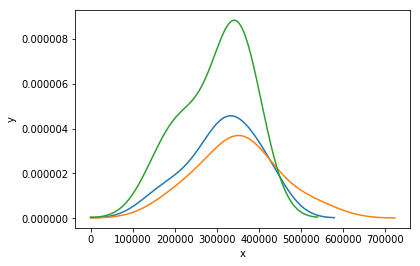

In [330]:
print(states)
results = calculate_distributions(states)
print(results)

{'dist': {'calc-pi-random-0': [570685.368262271, 235502.95075097558, 521434.57530854363, 430250.44474684645, 187727.6153158254, 573443.3265083549, 911477.9227674332, 541060.8915898766], 'calc-pi-random-1': [218624.4136200827, 31298.053384855884, 67943.73760629975, 736435.501123925, 769111.2786743998, 474177.7677230929, 378334.06999936246, 8151.555895780708], 'calc-pi-random-2': [699784.6550235737, 950085.4502447178, 707670.9443949845, 55057.452347867984, 494699.3522254073, 447689.6974002192, 201317.75993884625, 586348.7003430915], 'calc-pi-random-3': [940486.6742517051, 637663.0644010145, 331053.6608669923, 978546.9253359153, 636140.4692364781, 458274.9428710428, 227118.88635012964, 395998.73608792346], 'calc-pi-random-4': [864119.4544698525, 869923.5778985061, 161528.9397542272, 933287.3274488006, 679345.6600624172, 193849.21711025186, 354351.8380485308, 573227.7319461282], 'calc-pi-random-5': [883444.2728446493, 700606.170042496, 114335.31136559582, 965701.1772606097, 994958.42141614

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

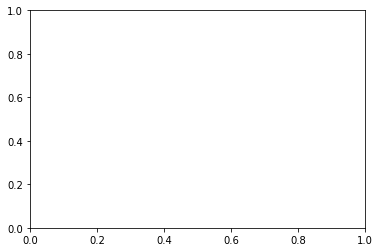

In [336]:
result = results['libmonitor.so.0.0.0']
print(result)
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

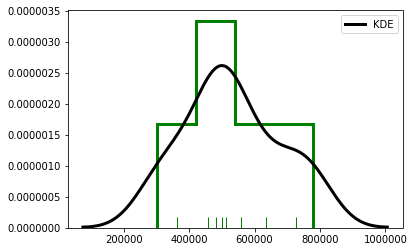

In [140]:
result = results['cpi']
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

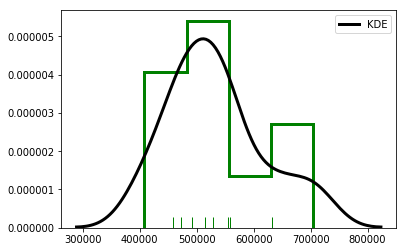

In [141]:
result = results['libmpi.so.12.0.5']
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [33]:
dataset = 'calc-pi-random-0'
state = read_gf(dataset)
print(state.df)

                      node  rank                  node.1  rank.1  time (inc)  \
0           <program root>     0          <program root>       0  453,871.15   
1           <program root>     1          <program root>       1   39,167.58   
2           <program root>     2          <program root>       2  177,874.70   
3           <program root>     3          <program root>       3  974,097.04   
4                     main     0                    main       0  500,962.77   
..                     ...   ...                     ...     ...         ...   
19       294:MPID_Finalize     3       294:MPID_Finalize       3   18,819.68   
20  162:MPIDI_CH3_Finalize     0  162:MPIDI_CH3_Finalize       0  930,129.75   
21  162:MPIDI_CH3_Finalize     1  162:MPIDI_CH3_Finalize       1  223,216.12   
22  162:MPIDI_CH3_Finalize     2  162:MPIDI_CH3_Finalize       2  570,273.13   
23  162:MPIDI_CH3_Finalize     3  162:MPIDI_CH3_Finalize       3  141,089.68   

    time  nid  rank.1.1                

AxesSubplot(0.125,0.125;0.775x0.755)


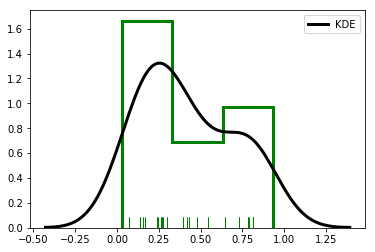

In [54]:
random = np.random.rand(state.df.shape[0])
ax = sns.distplot(random, hist=False, rug=True);
print(ax)

ax = sns.distplot(random, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [55]:
def iqr(a):
    """Calculate the IQR for an array of numbers."""
    a = np.asarray(a)
    q1 = stats.scoreatpercentile(a, 25)
    q3 = stats.scoreatpercentile(a, 75)
    return q3 - q1

In [182]:
def _freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From https://stats.stackexchange.com/questions/798/
    a = np.asarray(a)
    if len(a) < 2:
        return 1
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))

In [334]:
 def kde(data, gridsize=512, fft=True, kernel='gau', bw='scott', cut=3, clip=(-np.inf, np.inf)):
        print("Data is ", data)
        
        # assign binwidth using scott's factor
        if bw == 'scott':
            bw = stats.gaussian_kde(data).scotts_factor() * data.std(ddof=1)
        print("biwidth is: ", bw)    
        
        kde = smnp.KDEUnivariate(data)
        kde_gau = stats.gaussian_kde(data, bw_method=bw)
        
        # create the grid to fit the estimation.
        # clip = (0, data.max())
        # print(clip)
        support_min = max(data.min() - bw * cut, clip[0])
        support_max = min(data.max() + bw * cut, clip[1])
#         support_min = max(0, clip[0])
#         support_max = min(data.max(), clip[1])
        grid = np.linspace(support_min, support_max, gridsize)
        clip = (support_min, support_max)
        print("Grid is: ", grid.shape)
        
        kde.fit("gau", bw, fft, gridsize=gridsize, cut=cut, clip=clip)
        y = kde.density
        print("Y is: ", y.shape)
        x = grid
                
        return grid, y

In [346]:
def sshist(x, N=range(2, 501), SN=30):
    """
    Returns the optimal number of bins in a histogram used for density
    estimation.
    Optimization principle is to minimize expected L2 loss function between
    the histogram and an unknown underlying density function.
    An assumption made is merely that samples are drawn from the density
    independently each other.
    The optimal binwidth D* is obtained as a minimizer of the formula,
    (2K-V) / D^2,
    where K and V are mean and variance of sample counts across bins with width
    D. Optimal number of bins is given as (max(x) - min(x)) / D.
    Parameters
    ----------
    x : array_like
        One-dimensional data to fit histogram to.
    N : array_like, optional
        Array containing number of histogram bins to evaluate for fit.
        Default value = 500.
    SN : double, optional
        Scalar natural number defining number of bins for shift-averaging.
    Returns
    -------
    optN : int
        Optimal number of bins to represent the data in X
    N : double
        Maximum number of bins to be evaluated. Default value = 500.
    C : array_like
        Cost function C[i] of evaluating histogram fit with N[i] bins
    See Also
    --------
    sskernel, ssvkernel
    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "A method for selecting the bin size
           of a time histogram," in  Neural Computation 19(6), 1503-1527, 2007
           http://dx.doi.org/10.1162/neco.2007.19.6.1503
    """

    # determine range of input 'x'
    x_min = np.min(x)
    x_max = np.max(x)

    # get smallest difference 'dx' between all pairwise samples
    buf = np.abs(np.diff(np.sort(x)))
    dx = min(buf[buf > 0])

    # setup bins to evaluate
    N_MIN = 2
    N_MAX = min(np.floor((x_max - x_min) / (2*dx)), max(N))
    N_MAX = N_MAX.astype(int)  
    N = range(N_MIN, N_MAX+1)
    D = (x_max - x_min) / N

    # compute cost function over each possible number of bins
    Cs = np.zeros((len(N), SN))
    for i, n in enumerate(N):  # loop over number of bins
        shift = np.linspace(0, D[i], SN)
        for p, sh in enumerate(shift):  # loop over shift window positions

            # define bin edges
            edges = np.linspace(x_min + sh - D[i]/2,
                                x_max + sh - D[i]/2, N[i]+1)

            # count number of events in these bins
            ki = np.histogram(x, edges)

            # get mean and variance of events
            k = ki[0].mean()
            v = np.sum((ki[0] - k)**2) / N[i]

            Cs[i, p] = (2*k - v) / D[i]**2

    # average over shift window
    C = Cs.mean(axis=1)
    
    # get bin count that minimizes cost C
    idx = np.argmin(C)
    optN = N[idx]
    optD = D[idx]
    edges = np.linspace(x_min, x_max, optN)

    return optN, optD, edges, C, N

In [380]:
data = [999560.5, 522136.93900397, 505126.27075341, 714996.49335358, 565991.23472955]
sshist(data)

2 14
range(2, 15)
[3.74968151e-11 5.20864850e-11 5.97222000e-11 7.36301096e-11
 8.71289631e-11 1.07445419e-10 1.31852437e-10 1.48078332e-10
 1.68394788e-10 1.87620428e-10 2.04937139e-10 2.19526808e-10
 2.34389182e-10]


(2,
 247217.114623295,
 array([505126.27075341, 999560.5       ]),
 array([3.74968151e-11, 5.20864850e-11, 5.97222000e-11, 7.36301096e-11,
        8.71289631e-11, 1.07445419e-10, 1.31852437e-10, 1.48078332e-10,
        1.68394788e-10, 1.87620428e-10, 2.04937139e-10, 2.19526808e-10,
        2.34389182e-10]),
 range(2, 15))

In [378]:
def ssvkernel(x, tin=None, M=80, nbs=1e2, WinFunc='Boxcar'):
    """
    Generates a locally adaptive kernel-density estimate for one-dimensional
    data.
    The user provides a one-dimensional vector of samples drawn from some
    underlying unknown distribution, and optionally the values where they want
    to estimate the probability density of that distribution. The algorithm
    solves an optimization problem to identify variable bandwidths across the
    domain where the data is provided.
    The optimization is based on a principle of minimizing expected L2 loss
    function between the kernel estimate and an unknown underlying density
    function. An assumption is merely that samples are drawn from the density
    independently of each other.
    The locally adaptive bandwidth is obtained by iteratively computing optimal
    fixed-size bandwidths wihtihn local intervals. The optimal bandwidths are
    selected such that they are selected in the intervals that are gamma times
    larger than the optimal bandwidths themselves. The paramter gamma is
    optimized by minimizing the L2 risk estimate.
    Parameters
    ----------
    x : array_like
        The one-dimensional samples drawn from the underlying density
    tin : array_like, optional
        The values where the density estimate is to be evaluated in generating
        the output 'y'. Default value = None.
    M : int, optional
        The number of window sizes to evaluate. Default value = 80.
    nbs : int, optional
        The number of bootstrap samples to use in estimating the [0.05, 0.95]
        confidence interval of the output 'y'.
    WinFunc : string, optional
        The type of window function to use in estimating local bandwidth.
        Choose from one of 'Boxcar', 'Laplace', 'Cauchy' and 'Gauss'. Default
        value = 'Gauss'.
    Returns
    -------
    y : array_like
        The estimated density, evaluated at points t / tin.
    t : array_like
        The points where the density estimate 'y' is evaluated.
    optw : array_like
        The optimal local kernel bandwidths at 't'.
    gs : array_like
        The stiffness constants of the variables bandwidths evaluated.
    C : array_like
        Cost functions associated with stiffness constraints.
    confb95 : array_like
        The 5% and 95% confidence interval of the kernel density estimate 'y'.
        Has dimensions 2 x len(y). confb95[0,:] corresponds to the 5% interval,
        and confb95[1,:] corresponds to the 95% interval.
    yb : array_like
        The bootstrap samples used in estimating confb95. Each row corresponds
        to one bootstrap sample.
    See Also
    --------
    sshist, sskernel
    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "Kernel Bandwidth Optimization in 
           Spike Rate Estimation," in Journal of Computational Neuroscience 
           29(1-2): 171–182, 2010 http://dx.doi.org/10.1007/s10827-009-0180-4
    """

    # set argument 't' if not provided
    if tin is None:
        T = np.max(x) - np.min(x)
        dx = np.sort(np.diff(np.sort(x)))
        dt_samp = dx[np.nonzero(dx)][0]
        tin = np.linspace(np.min(x), np.max(x), min(np.ceil(T / dt_samp), 1e3))
        t = tin
        print(min(tin), max(tin),(x >= min(tin)) & (x <= max(tin)) )
#         x_ab = x[bool(x >= min(tin)) & (x <= max(tin))]
        x_ab = x
    else:
        T = np.max(x) - np.min(x)
        x_ab = x[(x >= min(tin)) & (x <= max(tin))]
        dx = np.sort(np.diff(np.sort(x)))
        dt_samp = dx[np.nonzero(dx)][0]
        if dt_samp > min(np.diff(tin)):
            t = np.linspace(min(tin), max(tin), min(np.ceil(T / dt_samp), 1e3))
        else:
            t = tin

    # calculate delta t
    dt = min(np.diff(t))

    # create the finest histogram
    thist = np.concatenate((t, (t[-1]+dt)[np.newaxis]))
    y_hist = np.histogram(x_ab, thist-dt/2)[0] / dt
    L = y_hist.size
    N = sum(y_hist * dt).astype(np.float)

    # initialize window sizes
    W = logexp(np.linspace(ilogexp(5 * dt), ilogexp(T), M))

    # compute local cost functions
    c = np.zeros((M, L))
    for j in range(M):
        w = W[j]
        yh = fftkernel(y_hist, w / dt)
        c[j, :] = yh**2 - 2 * yh * y_hist + 2 / (2 * np.pi)**0.5 / w * y_hist

    # initialize optimal ws
    optws = np.zeros((M, L))
    for i in range(M):
        Win = W[i]
        C_local = np.zeros((M, L))
        for j in range(M):
            C_local[j, :] = fftkernelWin(c[j, :], Win / dt, WinFunc)
        n = np.argmin(C_local, axis=0)
        optws[i, :] = W[n]

    # golden section search for stiffness parameter of variable bandwidths
    k = 0
    gs = np.zeros((30, 1))
    C = np.zeros((30, 1))
    tol = 1e-5
    a = 1e-12
    b = 1
    phi = (5**0.5 + 1) / 2
    c1 = (phi - 1) * a + (2 - phi) * b
    c2 = (2 - phi) * a + (phi - 1) * b
    f1 = CostFunction(y_hist, N, t, dt, optws, W, WinFunc, c1)[0]
    f2 = CostFunction(y_hist, N, t, dt, optws, W, WinFunc, c2)[0]
    while (np.abs(b-a) > tol * (abs(c1) + abs(c2))) & (k < 30):
        if f1 < f2:
            b = c2
            c2 = c1
            c1 = (phi - 1) * a + (2 - phi) * b
            f2 = f1
            f1, yv1, optwp1 = CostFunction(y_hist, N, t, dt, optws, W,
                                           WinFunc, c1)
            yopt = yv1 / np.sum(yv1 * dt)
            optw = optwp1
        else:
            a = c1
            c1 = c2
            c2 = (2 - phi) * a + (phi - 1) * b
            f1 = f2
            f2, yv2, optwp2 = CostFunction(y_hist, N, t, dt, optws, W,
                                           WinFunc, c2)
            yopt = yv2 / np.sum(yv2 * dt)
            optw = optwp2

        # capture estimates and increment iteration counter
        gs[k] = c1
        C[k] = f1
        k = k + 1

    # discard unused entries in gs, C
    gs = gs[0:k]
    C = C[0:k]

    # estimate confidence intervals by bootstrapping
    nbs = np.asarray(int(nbs))
    print(nbs)
    yb = np.zeros((nbs, tin.size))
    print(yb)
    for idx in range(nbs):
        Nb = np.random.poisson(lam=N)
        idx = np.random.randint(0, N, Nb)
        xb = x_ab[idx]
        thist = np.concatenate((t, (t[-1]+dt)[np.newaxis]))
        y_histb = np.histogram(xb, thist - dt / 2)[0]
        idx = y_histb.nonzero()
        y_histb_nz = y_histb[idx]
        t_nz = t[idx]
        yb_buf = np.zeros((L, ))
        for k in range(L):
            yb_buf[k] = np.sum(y_histb_nz * Gauss(t[k] - t_nz, optw[k])) / Nb
        yb_buf = yb_buf / np.sum(yb_buf * dt)
        yb[i, :] = np.interp(tin, t, yb_buf)
    ybsort = np.sort(yb, axis=0)
    y95b = ybsort[np.int(np.floor(0.05 * nbs)), :]
    y95u = ybsort[np.int(np.floor(0.95 * nbs)), :]
    confb95 = np.concatenate((y95b[np.newaxis], y95u[np.newaxis]), axis=0)

    # return outputs
    y = np.interp(tin, t, yopt)
    optw = np.interp(tin, t, optw)
    t = tin

    return y, t, optw, gs, C, confb95, yb


def CostFunction(y_hist, N, t, dt, optws, WIN, WinFunc, g):

    L = y_hist.size
    optwv = np.zeros((L, ))
    for k in range(L):
        gs = optws[:, k] / WIN
        if g > np.max(gs):
            optwv[k] = np.min(WIN)
        else:
            if g < min(gs):
                optwv[k] = np.max(WIN)
            else:
                idx = np.max(np.nonzero(gs >= g))
                optwv[k] = g * WIN[idx]

    # Nadaraya-Watson kernel regression
    optwp = np.zeros((L, ))
    for k in range(L):
        if WinFunc == 'Boxcar':
            Z = Boxcar(t[k]-t, optwv / g)
        elif WinFunc == 'Laplace':
            Z = Laplace(t[k]-t, optwv / g)
        elif WinFunc == 'Cauchy':
            Z = Cauchy(t[k]-t, optwv / g)
        else:  # WinFunc == 'Gauss'
            Z = Gauss(t[k]-t, optwv / g)
        optwp[k] = np.sum(optwv * Z) / np.sum(Z)

    # speed-optimized baloon estimator
    idx = y_hist.nonzero()
    y_hist_nz = y_hist[idx]
    t_nz = t[idx]
    yv = np.zeros((L, ))
    for k in range(L):
        yv[k] = np.sum(y_hist_nz * dt * Gauss(t[k]-t_nz, optwp[k]))
    yv = yv * N / np.sum(yv * dt)

    # cost function of estimated kernel
    cg = yv**2 - 2 * yv * y_hist + 2 / (2 * np.pi)**0.5 / optwp * y_hist
    Cg = np.sum(cg * dt)

    return Cg, yv, optwp


def fftkernel(x, w):
    # forward padded transform
    L = x.size
    Lmax = L + 3 * w
    n = 2 ** np.ceil(np.log2(Lmax))
    X = np.fft.fft(x, n.astype(np.int))

    # generate kernel domain
    f = np.linspace(0, n-1, n) / n
    f = np.concatenate((-f[0: np.int(n / 2 + 1)],
                        f[1: np.int(n / 2 - 1 + 1)][::-1]))

    # evaluate kernel
    K = np.exp(-0.5 * (w * 2 * np.pi * f) ** 2)

    # convolve and transform back from frequency domain
    y = np.real(np.fft.ifft(X * K, n))
    y = y[0:L]

    return y


def fftkernelWin(x, w, WinFunc):
    # forward padded transform
    L = x.size
    Lmax = L + 3 * w
    n = 2 ** np.ceil(np.log2(Lmax))
    X = np.fft.fft(x, n.astype(np.int))

    # generate kernel domain
    f = np.linspace(0, n-1, n) / n
    f = np.concatenate((-f[0: np.int(n / 2 + 1)],
                        f[1: np.int(n / 2 - 1 + 1)][::-1]))
    t = 2 * np.pi * f

    # determine window function - evaluate kernel
    if WinFunc == 'Boxcar':
        a = 12**0.5 * w
        K = 2 * np.sin(a * t / 2) / (a * t)
        K[0] = 1
    elif WinFunc == 'Laplace':
        K = 1 / (1 + (w * 2 * np.pi * f)**2 / 2)
    elif WinFunc == 'Cauchy':
        K = np.exp(-w * np.abs(2 * np.pi * f))
    else:  # WinFunc == 'Gauss'
        K = np.exp(-0.5 * (w * 2 * np.pi * f)**2)

    # convolve and transform back from frequency domain
    y = np.real(np.fft.ifft(X * K, n))
    y = y[0:L]

    return y


def Gauss(x, w):
    y = 1 / (2 * np.pi)**2 / w * np.exp(-x**2 / 2 / w**2)
    return y


def Laplace(x, w):
    y = 1 / 2**0.5 / w * np.exp(-(2**0.5) / w / np.abs(x))
    return y


def Cauchy(x, w):
    y = 1 / (np.pi * w * (1 + (x / w)**2))
    return y


def Boxcar(x, w):
    a = 12**0.5 * w
    y = 1 / a
    y[np.abs(x) > a / 2] = 0
    return y


def logexp(x):
    y = np.zeros(x.shape)
    y[x < 1e2] = np.log(1+np.exp(x[x < 1e2]))
    y[x >= 1e2] = x[x >= 1e2]
    return y


def ilogexp(x):
    y = np.zeros(x.shape)
    y[x < 1e2] = np.log(np.exp(x[x < 1e2]) - 1)
    y[x >= 1e2] = x[x >= 1e2]
    return y

In [379]:
ssvkernel(data)

/Users/jarus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/jarus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:238: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/jarus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:260: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


505126.27075341 999560.5 [ True  True  True  True  True]
100
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


TypeError: only integer scalar arrays can be converted to a scalar index

(array([8.09005478e-06, 4.04502739e-06, 0.00000000e+00, 0.00000000e+00,
        4.04502739e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.04502739e-06]),
 array([505126.27075341, 554569.69367807, 604013.11660273, 653456.53952739,
        702899.96245205, 752343.3853767 , 801786.80830136, 851230.23122602,
        900673.65415068, 950117.07707534, 999560.5       ]),
 <a list of 10 Patch objects>)

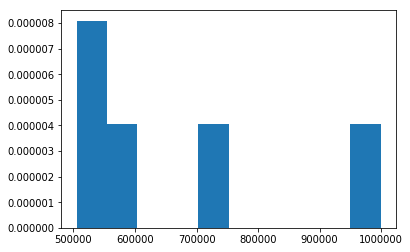

In [382]:
ser = 50*np.random.rand() * np.random.normal(10, 10, 100) + 20
ser = data
plt.hist(ser, normed=True)